Brief description of the project:  \
The data set I am using is a collection of earnings calls transcripts from the pharmaceutical industry. \
I will attempt to use the LDA and cosine similarity techniques to extract the topics from the transcripts, and then compute cosine similarities between the topic vectors.

## Problem 1: Topic Modeling
In this notebook I prepare the text data for topic modeling. The gensim LDA model is used to extract topics from the text data. I use the coherence score to evaluate the model and I visualize the topics using the pyLDAvis library. \
I choose the LDA model with the highest coherence to create the topic allocations for each earnings call, and I compute a cosine similarity for each document within each company using the vector of the topic allocations comparing the vectors within the same company. \
I modified the code used by the authors of the Sam Arts repository to create a backward and forward cosine similarity for all documents. I did not do it by slicing by year, as my dataset is small enough that doing it at an individual document level is feasible. \
After this do a correlation analysis between the different cosine similarity measures ( within company and across all companies). \

In [4]:
import pandas as pd
import pickle
# import numpy as np # linear algebra
# # import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from datetime import datetime
import regex as re
import pickle
import gensim
import finEC.datapreproc as dpp
from gensim import models
from gensim import corpora
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
import gensim
import numpy as np
import nltk
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer   
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel
# Download stopwords
nltk.download('punkt')
# gensim implementation 
from gensim.models import LdaMulticore, TfidfModel
from gensim.corpora import Dictionary
import multiprocessing

import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import operator
import re
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/djtom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/djtom/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/djtom/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/djtom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/djtom/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Loading the data.

In [5]:
ec=pickle.load(open("../data/Sentiment_Market_Pharma/earnings_call_top10_ph.pickle", "rb"))
ec=ec.reset_index()

Preprocessing data consists of using different huggingface transformers for Named Entity Recognition to remove names and then using lowercase BERT to remove punctuation.

In [6]:
ec=dpp.process_ec_v0(ec)
txt=ec.cleanedec.tolist()

In [7]:
# simplify Penn tags to n (NOUN), v (VERB), a (ADJECTIVE) or r (ADVERB)
def simplify(penn_tag):
    pre = penn_tag[0]
    if (pre == 'J'):
        return 'a'
    elif (pre == 'R'):
        return 'r'
    elif (pre == 'V'):
        return 'v'
    else:
        return 'n'

In [8]:
def preprocess(text):
    stop_words = stopwords.words('english')
    toks = gensim.utils.simple_preprocess(str(text), deacc=True)
    wn = WordNetLemmatizer()
    # return [wn.lemmatize(tok, simplify(pos)) for tok, pos in nltk.pos_tag(toks) if tok not in stop_words]
    return [tok for tok in toks if tok not in stop_words]

In [9]:
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = stopwords.words('english')

def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

def tokenize(words, modulation):
    tokens = re.split(r'\W+', words)
    stems = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        lowers=abbr_or_lower(token)
        if re.search('[a-zA-Z]', lowers):
            if modulation==1:
                w = porter.stem(lowers)
            if modulation==2:
                w = lmtzr.lemmatize(lowers)
            if modulation==0:
                w = lowers
            if w not in stop_words:
              stems.append(w)
    return stems

In [10]:
# reproducibility
seed = 42
# python RNG
import random
random.seed(seed)
# numpy RNG
import numpy as np
np.random.seed(seed)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  

In [113]:
#remember that modulation fixes the pre-processing
#let's experiment with 0 (nothing) vs. 1 (stemming) vs. 2 (lemmatizing)
texts=[tokenize(document,2) for document in txt]

In [12]:
#making bigrams and trigrams with collocations 
bigram = gensim.models.Phrases(texts, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[texts], threshold=1)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_bigrams = [bigram_mod[doc] for doc in texts]
texts_trigrams = [trigram_mod[doc] for doc in texts]

In [13]:
topicnumber=10
id2word = corpora.Dictionary(texts_trigrams)
id2word.filter_extremes(no_below = 110, no_above=0.4)
corpus = [id2word.doc2bow(text) for text in texts_trigrams]

lda_model = gensim.models.ldamodel.LdaModel(
          corpus=corpus, id2word=id2word, num_topics=topicnumber, random_state=100, 
          update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True
)

In [14]:
id2word,corpus

(<gensim.corpora.dictionary.Dictionary at 0x7f6440231400>,
 [[(0, 1),
   (1, 2),
   (2, 1),
   (3, 2),
   (4, 1),
   (5, 1),
   (6, 1),
   (7, 1),
   (8, 1),
   (9, 1),
   (10, 1),
   (11, 1),
   (12, 7),
   (13, 1),
   (14, 1),
   (15, 1),
   (16, 2),
   (17, 4),
   (18, 3),
   (19, 1),
   (20, 1),
   (21, 1),
   (22, 1),
   (23, 1),
   (24, 1),
   (25, 1),
   (26, 4),
   (27, 1),
   (28, 4),
   (29, 1),
   (30, 1),
   (31, 1),
   (32, 1),
   (33, 2),
   (34, 2),
   (35, 1),
   (36, 1),
   (37, 1),
   (38, 1),
   (39, 3),
   (40, 2),
   (41, 3),
   (42, 2),
   (43, 1),
   (44, 2),
   (45, 2),
   (46, 2),
   (47, 1),
   (48, 1),
   (49, 1),
   (50, 1),
   (51, 3),
   (52, 1),
   (53, 1),
   (54, 1),
   (55, 1),
   (56, 7),
   (57, 1),
   (58, 2),
   (59, 2),
   (60, 2),
   (61, 1),
   (62, 2),
   (63, 1),
   (64, 1),
   (65, 2),
   (66, 1),
   (67, 2),
   (68, 4),
   (69, 1),
   (70, 1),
   (71, 2),
   (72, 1),
   (73, 1),
   (74, 1),
   (75, 2),
   (76, 1),
   (77, 1),
   (78, 1),
   

In [15]:
lda_model.print_topics(topicnumber)

[(0,
  '0.013*"pfizer" + 0.013*"lilly" + 0.012*"john" + 0.012*"animal_health" + 0.008*"biosimilars" + 0.008*"volume_growth" + 0.006*"fx" + 0.006*"exchange" + 0.006*"ph" + 0.006*"phase_ii"'),
 (1,
  '0.040*"weve" + 0.023*"youre" + 0.022*"weve_seen" + 0.021*"dont" + 0.015*"im" + 0.014*"youve" + 0.013*"ill" + 0.013*"whats" + 0.010*"hospital" + 0.009*"dont_think"'),
 (2,
  '0.016*"second_line" + 0.015*"overall_survival" + 0.011*"indiscernible" + 0.011*"astrazeneca" + 0.009*"breast_cancer" + 0.008*"survival" + 0.008*"testing" + 0.008*"endpoint" + 0.007*"non_small" + 0.007*"immuno_oncology"'),
 (3,
  '0.016*"please_go" + 0.012*"operating_income" + 0.011*"constant_currency" + 0.009*"division" + 0.009*"indiscernible" + 0.008*"pharma" + 0.008*"percentage_point" + 0.007*"ph" + 0.007*"insulin" + 0.006*"operating_profit"'),
 (4,
  '0.019*"lung" + 0.015*"tumor" + 0.013*"non_small" + 0.013*"cell_lung" + 0.012*"animal_health" + 0.010*"small_cell" + 0.009*"chemotherapy" + 0.009*"regimen" + 0.008*"mela

In [16]:
def viz_model(model, modeldict):
    ntopics = model.num_topics
    # top words associated with the resulting topics
    topics = ['Topic {}: {}'.format(t,modeldict[w]) 
              for t in range(ntopics) 
              for w,p in model.get_topic_terms(t, topn=1)]
              
    terms = [modeldict[w] for t in range(ntopics)
             for w, p in model.get_topic_terms(t, topn=3)]
    id_terms = [w for t in range(ntopics)
             for w, p in model.get_topic_terms(t, topn=3)]
    fig,ax=plt.subplots(figsize=(12, 6))
    print(model.get_topics()[:, id_terms].shape)
    ax.imshow(model.get_topics()[:, id_terms])  # plot the numpy matrix
    ax.set_xticks(np.arange(30))  # set up the x-axis
    ax.set_xticklabels(terms, rotation=90)
    ax.set_yticks(np.arange(ntopics))  # set up the y-axis
    ax.set_yticklabels(topics)
    plt.show()

(10, 30)


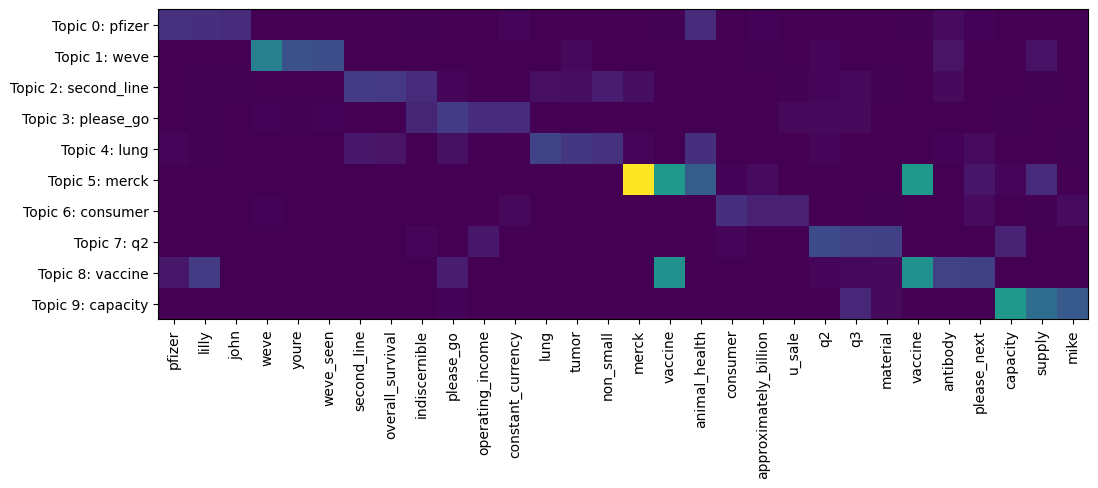

In [17]:
viz_model(lda_model, id2word)

In [18]:
def topics(lda_model, vectorizer, n_top_words):

    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(lda_model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [19]:
# Visualize the topic model using PyLDAvis
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.display(lda_display)


## Doing topic modeling based on highest coherence

In [20]:
# initialize list to save coherence values and lda model
coherence_values = []
lda_models = []

# for each value of n
for n in range(2, 21):

    # train the lda model with n topics
    model = LdaMulticore(corpus, 
                         id2word=id2word,
                         num_topics=n,
                         workers=min(8, multiprocessing.cpu_count()-1), # number of cores
                         passes=10, # training passes
                         chunksize=200, # no. of documents in each training chuck
                         )
    # add the model to the corresponding initialized list
    lda_models.append(model)
    
    # create coherence model with the above trained lda model
    coherencemodel = CoherenceModel(model=model, texts=texts_trigrams, dictionary=id2word, coherence='c_v')
    
    # add the value for n and the coherence to the corresponding initialized list
    coherence_val = coherencemodel.get_coherence()
    print(n, coherence_val)
    coherence_values.append( (n, coherence_val) )

2 0.29216560779194667
3 0.3350031329776868
4 0.34495365014011437
5 0.36918873541217945
6 0.3716180933098519
7 0.3813608838303092
8 0.36909773423791614
9 0.3684890973121351
10 0.35139148046917484
11 0.3343924565955165
12 0.3745638407362621
13 0.36530452986500167
14 0.3555275716869894
15 0.3540287382726048
16 0.3668781172321708
17 0.34945199998412724
18 0.3660560327010699
19 0.33100122922534786
20 0.31926175251349875


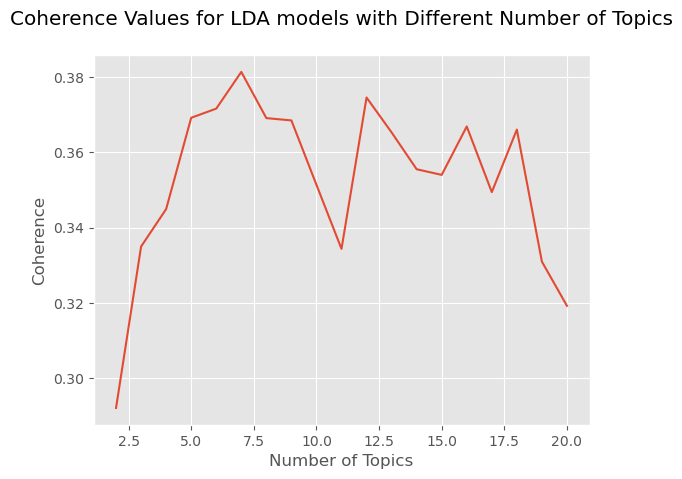

In [21]:
plt.style.use('ggplot')
plt.plot(*zip(*coherence_values))
plt.title('Coherence Values for LDA models with Different Number of Topics\n')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.show()

In [22]:
#let's create a reusable function that for a list of documents, creates a dictionary and a corpus, finds the best number of topics based on the coherence score and returns the best lda model.
def bestlda_coherence(listdocs):
    texts=[tokenize(document,2) for document in listdocs]
    #making bigrams and trigrams with collocations 
    bigram = gensim.models.Phrases(texts, min_count=1, threshold=1)
    trigram = gensim.models.Phrases(bigram[texts], threshold=1)  

    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    texts_bigrams = [bigram_mod[doc] for doc in texts]
    texts_trigrams = [trigram_mod[doc] for doc in texts]
    id2word = corpora.Dictionary(texts_trigrams)
    id2word.filter_extremes(no_below = 110, no_above=0.4)
    corpus = [id2word.doc2bow(text) for text in texts_trigrams]
    # initialize list to save coherence values and lda model
    coherence_values = []
    lda_models = []

    # for each value of n
    for n in range(2, 21):

        # train the lda model with n topics
        model = LdaMulticore(corpus, 
                            id2word=id2word,
                            num_topics=n,
                            workers=min(8, multiprocessing.cpu_count()-1), # number of cores
                            passes=10, # training passes
                            chunksize=200, # no. of documents in each training chuck
                            )
        # add the model to the corresponding initialized list
        lda_models.append(model)
        
        # create coherence model with the above trained lda model
        coherencemodel = CoherenceModel(model=model, texts=texts_trigrams, dictionary=id2word, coherence='c_v')
        
        # add the value for n and the coherence to the corresponding initialized list
        coherence_val = coherencemodel.get_coherence()
        # print(n, coherence_val)
        coherence_values.append( (n, coherence_val) )
        bestmodel=lda_models[np.argmax([i[1] for i in coherence_values])]

    topicallocation=[]
    for doc in texts_trigrams:
        topicallocation.append(bestmodel.get_document_topics(bow=id2word.doc2bow(doc)))
    return topicallocation
        

In [23]:
allocationacrossallcompanies=bestlda_coherence(txt)

In [24]:
# ec['lda_all_companies']=allocationacrossallcompanies
for i,t in enumerate(allocationacrossallcompanies):
    for topic, prob in t:
        topic='topic'+str(topic)
        ec.loc[ec.index[i],topic]=prob
ec.fillna(0, inplace=True)
ec['topic_all_vec']=ec[['topic0','topic1','topic2','topic3','topic4','topic5','topic6','topic7']].apply(lambda x : x.to_numpy(), axis=1)

In [25]:
# ec.to_pickle("ec_with_topics.pickle")

In [26]:
# ec=pickle.load(open("ec_with_topics.pickle", "rb"))
# ec.drop(['index'],axis=1,inplace=True)

(51, 51)


<AxesSubplot:>

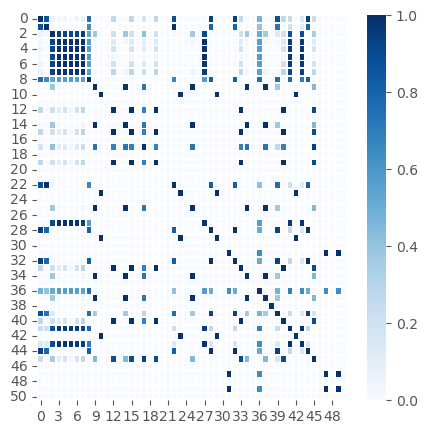

In [27]:
#computing the cosine similarity between the topics of the earnings calls of the same company
nvs=ec[ec['symbol']=='NVS'].sort_values(by='date')
vectors=np.array(nvs.topic_all_vec.to_list())
cosine_matrix=cosine_similarity(vectors)
#since we now have cosine similarity between the topics of the earnings calls of the same company, we can plot the cosine similarity matrix
print(cosine_matrix.shape)
plt.figure(figsize=(5,5))
sns.heatmap(cosine_matrix, annot=False, fmt=".2f", linewidths=.5, cmap='Blues')

In [28]:
#for each row in the ec dataframe, we average the cosine similarity of that row with the previous 5 calls
def get_avg_cosine(i,n,cosine_matrix):
    if i<n and i>0:
        return np.mean(cosine_matrix[0:i,i])  
    elif i==0:
        return cosine_matrix[0,0]   
    else:
        return np.mean(cosine_matrix[i-n:i,i])

Text(0, 0.5, 'Average Cosine Similarity')

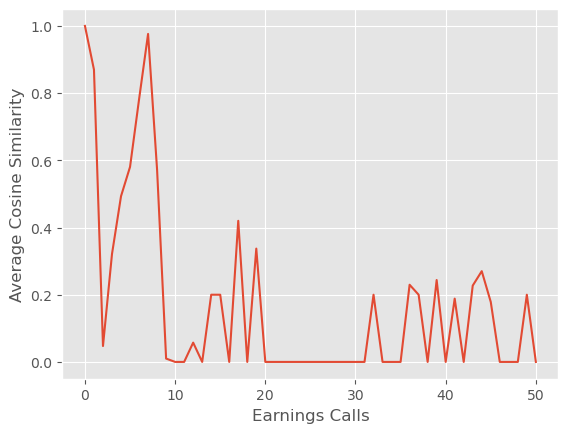

In [29]:
nvs.reset_index(inplace=True)
nvs['avg_cosine_5']=nvs.index.map(lambda x: get_avg_cosine(x,5,cosine_matrix))
nvs['avg_cosine_10']=nvs.index.map(lambda x: get_avg_cosine(x,10,cosine_matrix))
nvs['avg_cosine_20']=nvs.index.map(lambda x: get_avg_cosine(x,20,cosine_matrix))
plt.plot(nvs['avg_cosine_5'])
plt.xlabel('Earnings Calls')
plt.ylabel('Average Cosine Similarity')
#plotting the average cosine similarity of the earnings calls of the same company over time

In [30]:
ec.columns

Index(['index', 'symbol', 'quarter', 'year', 'date', 'content', 'cleanedec',
       'topic11', 'topic12', 'topic3', 'topic5', 'topic6', 'topic9', 'topic2',
       'topic10', 'topic15', 'topic8', 'topic0', 'topic13', 'topic7', 'topic4',
       'topic1', 'topic14', 'topic_all_vec'],
      dtype='object')

In [31]:
def cosine(series,n):
    series.reset_index(inplace=True)
    vectors=np.array(series.to_list())
    cosine_matrix=cosine_similarity(vectors)
    series.index.map(lambda x: get_avg_cosine(x,5,cosine_matrix))
    return cosine_matrix

In [32]:
ec.symbol

0      PFE
1      PFE
2      PFE
3      PFE
4      PFE
      ... 
510    MRK
511    MRK
512    MRK
513    MRK
514    MRK
Name: symbol, Length: 515, dtype: object

In [ ]:
#now let us repeat all the previous steps for all the companies
ec[['avg_cosine_5','avg_cosine_10','avg_cosine_20']]=np.nan
for ticker in ec.symbol.unique():
    company=ec[ec['symbol']==ticker].sort_values(by='date')
    vectors=np.array(company.topic_all_vec.to_list())
    cosine_matrix=cosine_similarity(vectors)
    print(ticker,cosine_matrix.shape)
    company=company.reset_index()
    company['avg_cosine_5']=company.index.map(lambda x: get_avg_cosine(x,5,cosine_matrix))
    company['avg_cosine_10']=company.index.map(lambda x: get_avg_cosine(x,10,cosine_matrix))
    company['avg_cosine_20']=company.index.map(lambda x: get_avg_cosine(x,20,cosine_matrix))
    
    company.index=company['index']
    company.drop(['index'],axis=1,inplace=True)
    # print(company.shape,ec.shape)
    # ec.update(company[['avg_cosine_5','avg_cosine_10','avg_cosine_20']])
    ec=ec.merge(company[['avg_cosine_5','avg_cosine_10','avg_cosine_20']],left_index=True,right_index=True,how='outer')

PFE (59, 59)
(59, 27) (515, 27)
NVO (42, 42)
(42, 33) (573, 30)
BMY (59, 59)
(59, 33) (2992, 33)
JNJ (59, 59)
(59, 39) (146716, 36)


: 

: 

: 

Let's take a shot at creating a cosine similarity measure across all companies using the code in the repository of the Sam Arts paper. 

In [34]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 3 14:15:00 2020

@authors: Juan Carlos Gomez
          Sam Arts
          Jianan Hou

@emails: jc.gomez@ugto.mx
         sam.arts@kuleuven.be
         jianan.hou@kuleuven.be

@description: Cleans the patent_concatenated.txt file by removing NLTK stop-
words, other common stopwords, greek letters, symbols and roman numerals.
Additionally it apply stemmming to each word using the SnowBall method
from NLTK. It also removes words that appears in only one patent.
The output consists of two files, keywords_vocabulary.txt, that
contains the list of all unique unigrams in all the transcripts, and
keywords_all.txt, that contains the clean text for each patent. The text
is the list of all unigrams for each patent.

This code is part of the article: "Natural Language Processing to Identify the
Creation and Impact of New Technologies in Patent Text: Code, Data, and New
Measures"

"""



def checkRoman(token):
    """
    Check if a token is a roman numeral.


    Parameters
    ----------
    token : A string.

    Returns
    -------
    True/False : A true value

    """
    re_pattern = '[mdcxvi]+[a-z]'
    if re.fullmatch(re_pattern, token):
        return True
    return False


aux_dir = '' # Original data
data_dir = '' # Processed data
# Input common files
greek_file = aux_dir+'greek.txt'
symbol_file = aux_dir+'symbols.txt'
stop_file = aux_dir+'additional_stopwords.txt'
concat_file = data_dir+'patent_concatenated.txt'
pno_file = data_dir+'patent_number.txt'
# Output files for backward_cosine measure
voc_file = data_dir+'backward_cosine/keywords_vocabulary.txt'
uni_file = data_dir+'backward_cosine/keywords_all.txt'

# print('Reading patent numbers...')
patents = list(ec.index)
# with open(pno_file, 'r') as pno_reader:
#     for line in pno_reader:
#         patents.append(line.strip())
# print('Patent numbers read!')

# print('Reading greek letters, symbols and stop words to remove...')
list_replace = []
stemmer = SnowballStemmer('english')
print('Cleaning transcripts...')
print('transcripts cleaned!')
clean_patents=texts
print('Forming and cleaning vocabulary...')
d_words = {}
for tokens in clean_patents:
    for token in set(tokens):
        d_words[token] = d_words.get(token, 0) + 1

# Eliminate words appearing in only one patent
list_words = list(d_words)
d_dirty = {}
for word in list_words:
    d_dirty[word] = d_words[word]
    if d_words[word] < 2:
        del d_words[word]
print('Vocabulary formed!')

# print('Cleaning transcripts data using the vocabulary...')
# Eliminate words not in clean vocabulary
for i in range(len(clean_patents)):
    tokens = clean_patents[i]
    tokens_clean = [token for token in tokens if token in d_words]
    clean_patents[i] = tokens_clean
print('Transcript data cleaned!')

voc_sorted = sorted(d_words.items(), key=operator.itemgetter(1), reverse=True)

# print('Saving vocabulary...')
# Write vocabulary
# with open(voc_file, 'w', encoding='utf-8') as voc_writer:
#     for pair in voc_sorted:
#         # voc_writer.write(pair[0]+' '+str(pair[1])+'\n')
#         pass
# print('Vocabulary saved!')

# print('Saving transcripts data...')
# Save patent number and patent text
# with open(uni_file, 'w', encoding='utf-8') as uni_writer:
#     for tokens, patent in zip(clean_patents, patents):
#         line = ' '.join(tokens)
#         # uni_writer.write(str(patent)+','+line+'\n')
# print('transcript data saved!')


Cleaning transcripts...
transcripts cleaned!
Forming and cleaning vocabulary...
Vocabulary formed!
Transcript data cleaned!


In [137]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 3 14:15:00 2020

@authors: Juan Carlos Gomez
          Sam Arts
          Jianan Hou

@emails: jc.gomez@ugto.mx
         sam.arts@kuleuven.be
         jianan.hou@kuleuven.be

@description: Computes the averegar cosine similarity of a focus patent
regarding the patents from 5 years in the past (backwward) and 5 years in
the future (forward). The output is a set of sequential files
patent_cosine_all_i.txt, where i is an index for the number of file. Each
file correspond to a set of years. In each file there are three columns, the
first one is the focus patent, the second the average backward cosine
similarity and the third one the average forward cosine similarity.

This code is part of the article: "Natural Language Processing to Identify the
Creation and Impact of New Technologies in Patent Text: Code, Data, and New
Measures"

"""



def my_tokenizer(s):
    """
    Split a string s by spaces.


    Parameters
    ----------
    s : The string.

    Returns
    -------
    s.split() : A list with the resulting substrings from the split

    """
    return s.split()


def collect_blocks(d_blocks, ayear, n):
    """
    Collect a block of patents for a window of n years regarding a focus
    year.
    If n is positive the patents are from the future.
    If n is negative the patents are from the past.


    Parameters
    ----------
    d_blocks : A dictionary of patent blocks, the key is the year, and the
              value is a list of indexes of the patents belongin to that year.
    ayear: The focus year
    n: The window size

    Returns
    -------
    block : A list with all the patents in the window of n years (past or
            or future)

    """
    inc = int(n/abs(n))
    ayears = list(range(ayear+inc, ayear+n+inc, inc))
    block = []
    for i in ayears:
        if i in d_blocks:
            block.extend(d_blocks[i])
    return block


def comp_sim(block_a, block_p, block_f):
    """
    Compute the similarity of a group of patents from block_a starting at
    slice_start and ending in slice_end regarding a block of patents from
    the past (block_p) and a block of patents from the future (bloc_f)


    Parameters
    ----------
    slice_start : The initial index to consider the group of patents
    slic_end : The final index to consider the group of patents
    block_a : An array containing the patent data to extract the group
    block_p : An array containing patents from the past
    block_f : An array containing patents from the future

    Returns
    -------
    sim_p : A sparse array with the similarities between the group of patents
            and the patents in the past
    sim_f : A sparse array with the similarities between the group of patents
            and the patents in the future

    """
    if block_p.shape[0] > 0:
        sim_p = block_a.dot(block_p.T).mean(axis=1)
        sim_p = np.squeeze(np.asarray(sim_p))
        if sim_p.shape:
            sim_p = list(sim_p)
        else:
            sim_p = [sim_p[()]]
    else:
        sim_p = [0]*block_a.shape[0]

    if block_f.shape[0] > 0:
        sim_f = block_a.dot(block_f.T).mean(axis=1)
        sim_f = np.squeeze(np.asarray(sim_f))
        if sim_f.shape:
            sim_f = list(sim_f)
        else:
            sim_f = [sim_f[()]]
    else:
        sim_f = [0]*block_a.shape[0]
    return sim_p, sim_f


data_dir = '' # Processed data
# Input common files
ayear_file = data_dir+'patent_ayear.txt'
# Output file for backward_cosine measure
idx_file = data_dir+'backward_cosine/keywords_all_idx.txt'

# Reading patent data
# print('Reading transcript unigrams and transcript numbers...')
d_ayear = {}
d_blocks = {}
d_pnos = {}
patents = []
pnos = []
i = 0
patents=[' '.join(i) for i in clean_patents]
patents=[re.sub(r'\w*\d\w*','',i) for i in patents]
patents=[' '.join(tokenize(document,2)) for document in patents]
print('Vectorizing transcripts to TF...')
vectorizer = CountVectorizer(analyzer=str.split,min_df=10,max_df=500,ngram_range=(1,3),stop_words='english')
patents_tf = vectorizer.fit_transform(patents)
print('Transcripts vectorized to TF!')

print('Normalizing TF matrix...')
patents_tf = normalize(patents_tf, norm='l2')
print('TF matrix normalized!')

print('Computing similarities for all earnings calls in the past and future of the current transcript...')
# for i in sequ:
cosine_file = data_dir+'backward_cosine/files/patent_cosine_all_'
cosine_file += str(i)+'.txt'
# with open(cosine_file, 'w', encoding='utf-8') as cosine_writer:
    # print('Block of years:', i)
results_past = []
results_future = []
for i,patent in enumerate(patents_tf):
    start = time.time()
    block_current = patents_tf[i]
    block_past = patents_tf[:i]
    block_future = patents_tf[i+1:]

    sim_p, sim_f = comp_sim(
                                block_current,
                                block_past, block_future)
    results_past.extend(sim_p)
    results_future.extend(sim_f)
    end = time.time()
end = time.time()
print('Total time:', end-start)
print('Similarities computed!')


Vectorizing transcripts to TF...
Transcripts vectorized to TF!
Normalizing TF matrix...
TF matrix normalized!
Computing similarities for all earnings calls in the past and future of the current transcript...
Total time: 0.010072708129882812
Similarities computed!


In [144]:
sorted(list(vectorizer.vocabulary_.keys()))

['aa',
 'aaa',
 'aacr',
 'aameo',
 'aasld',
 'abbott',
 'abbv',
 'abbvie',
 'abbvieinvestor',
 'abbvies',
 'abdominal',
 'abemaciclib',
 'abilify',
 'ability',
 'abiraterone',
 'ablation',
 'able',
 'abnormal',
 'abroad',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'absorbing',
 'absorbs',
 'absorption',
 'abstract',
 'abt',
 'abuse',
 'ac',
 'aca',
 'academia',
 'academic',
 'academy',
 'acalabrutinib',
 'acc',
 'accelerate',
 'accelerated',
 'accelerates',
 'accelerating',
 'acceleration',
 'accelerator',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'access',
 'accessed',
 'accessible',
 'accessing',
 'accident',
 'accommodate',
 'accompanied',
 'accompanies',
 'accompanying',
 'accomplish',
 'accomplished',
 'accomplishment',
 'accordance',
 'according',
 'accordingly',
 'account',
 'accountability',
 'accountable',
 'accounted',
 'accounting',
 'accretion',
 'accretive',
 'accrual',
 'accrue',
 'accrued',
 'accruing',
 'accumulate',
 'accum

In [140]:
#check if there are numbers in the vocabulary
count = sum(1 for item in list(vectorizer.vocabulary_.keys()) if re.match(r'[0-9]+', str(item)))
print(count)

0


In [119]:
#descriptive analysis of the backward cosine similarity for the last earnings call of NVS
len(vectorizer.get_feature_names_out().tolist())

6607

In [167]:
tfidffilter=[10,405,75,205]
pd.DataFrame(patents_tf[tfidffilter].toarray(),index=ec.symbol[tfidffilter],columns=vectorizer.get_feature_names_out().tolist())[['carcinoma','diabetes','gaap','diagnosis','eps','profit']]

carcinoma  diabetes      gaap  diagnosis       eps    profit
symbol                                                              
PFE      0.029776  0.000000  0.014888   0.007444  0.044664  0.000000
LLY      0.000000  0.034806  0.110218   0.000000  0.034806  0.005801
NVO      0.000000  0.152848  0.000000   0.000000  0.000000  0.062271
JNJ      0.000000  0.011825  0.017737   0.000000  0.041387  0.005912

In [163]:
vectorizer.get_feature_names_out().tolist()[5000:7500]

['profit',
 'profitability',
 'profitable',
 'profound',
 'prognosis',
 'program',
 'progress',
 'progressed',
 'progressing',
 'progression',
 'progressive',
 'progressively',
 'project',
 'projected',
 'projecting',
 'projection',
 'proliferation',
 'prolonged',
 'promacta',
 'prominent',
 'promise',
 'promised',
 'promising',
 'promote',
 'promoted',
 'promoting',
 'promotion',
 'promotional',
 'prompted',
 'pronged',
 'pronounced',
 'proof',
 'propel',
 'propensity',
 'proper',
 'properly',
 'property',
 'prophylactic',
 'prophylaxis',
 'proportion',
 'proposal',
 'propose',
 'proposed',
 'proposing',
 'proposition',
 'proprietary',
 'proquad',
 'prosecute',
 'prospect',
 'prospective',
 'prospectively',
 'prosper',
 'prostate',
 'protease',
 'protect',
 'protected',
 'protecting',
 'protection',
 'protective',
 'protects',
 'protein',
 'protocol',
 'proton',
 'proud',
 'prove',
 'proved',
 'proven',
 'provide',
 'provided',
 'provider',
 'provides',
 'providing',
 'province',
 'pr

In [169]:
ec['backward_cosine']=results_past
ec['forward_cosine']=results_future
ec.head()

index symbol  quarter  year        date  \
0      0    PFE        4  2007  2008-01-24   
1      0    PFE        3  2007  2007-10-18   
2      0    PFE        2  2007  2007-07-18   
3      0    PFE        4  2008  2009-01-28   
4      0    PFE        1  2008  2008-04-17   

                                             content  \
0  Operator: Amal Naj, Head of Development. Pleas...   
1  Operator: Mr. Amal Naj, Senior VicePresident o...   
2  Operator: Amal Naj, Head of Investor Relations...   
3  Operator: Good morning ladies and gentlemen an...   
4  Operator: Now we have Amal Naj, Head of Invest...   

                                           cleanedec   topic11   topic12  \
0   amal naj, head of development. please begin t...  0.036371  0.961594   
1   mr. amal naj, senior vicepresident of investo...  0.224595  0.678540   
2   al naj, head of investor relations, you may b...  0.034465  0.692768   
3    ladies and gentlemen and welcome to quarter ...  0.000000  0.940265   
4   now we have amal naj, head of investor develo...  0.000000  0.864418   

     topic3  ...  topic8  topic0  topic13  topic7  topic4  topic1  topic14  \
0  0.000000  ...     0.0     0.0      0.0     0.0     0.0     0.0      0.0   
1  0.067187  ...     0.0     0.0      0.0     0.0     0.0     0.0      0.0   
2  0.000000  ...     0.0     0.0      0.0     0.0     0.0     0.0      0.0   
3  0.000000  ...     0.0     0.0      0.0     0.0     0.0     0.0      0.0   
4  0.000000  ...     0.0     0.0      0.0     0.0     0.0     0.0      0.0   

                                       topic_all_vec  backward_cosine  \
0           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]         0.000000   
1  [0.0, 0.0, 0.0, 0.06718678027391434, 0.0, 0.02...         0.721502   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.27094921469688416,...         0.551269   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0578444339334...         0.549033   
4           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]         0.647499   

   forward_cosine  
0        0.359124  
1        0.357835  
2        0.337112  
3        0.339142  
4        0.356641  

[5 rows x 26 columns]

Problem 1

Checking correlation between the two measures.

In [ ]:
corr=ec[['backward_cosine','forward_cosine','avg_cosine_5','avg_cosine_10','avg_cosine_20']].corr()
corr

backward_cosine  forward_cosine  avg_cosine_5  avg_cosine_10  \
backward_cosine         1.000000        0.060449      0.035056       0.031813   
forward_cosine          0.060449        1.000000     -0.068564      -0.050105   
avg_cosine_5            0.035056       -0.068564      1.000000       0.978548   
avg_cosine_10           0.031813       -0.050105      0.978548       1.000000   
avg_cosine_20           0.032328       -0.035319      0.938645       0.977066   

                 avg_cosine_20  
backward_cosine       0.032328  
forward_cosine       -0.035319  
avg_cosine_5          0.938645  
avg_cosine_10         0.977066  
avg_cosine_20         1.000000

Great! Let's plot this for a better visualization.

<Axes: >

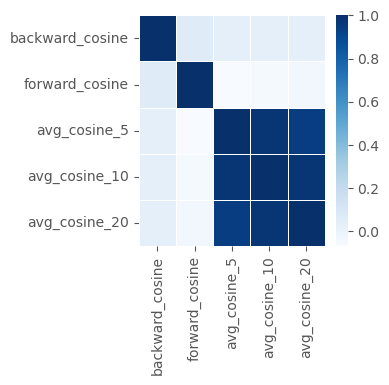

In [ ]:
plt.figure(figsize=(3,3))
sns.heatmap(corr, annot=False, fmt=".2f", linewidths=.5, cmap='Blues')

We can conclude that there is very little correlation between the within company cosine similarity and the backward cosine similarity across all companies. This was expected as the dataset is a bit small, so this could be just a result of that.

In [172]:
ec.columns

Index(['index', 'symbol', 'quarter', 'year', 'date', 'content', 'cleanedec',
       'topic11', 'topic12', 'topic3', 'topic5', 'topic6', 'topic9', 'topic2',
       'topic10', 'topic15', 'topic8', 'topic0', 'topic13', 'topic7', 'topic4',
       'topic1', 'topic14', 'topic_all_vec', 'backward_cosine',
       'forward_cosine'],
      dtype='object')

In [174]:
ec[['index', 'symbol', 'quarter', 'year', 'date', 'content', 'topic_all_vec', 'backward_cosine',
       'forward_cosine']].to_csv('../data/ec_backwardcosine0107.csv',index=False)

In [ ]:
stock_prices = pd.merge(num, ec, how='outer', left_on=['Date', 'Ticker'], right_on=['date', 'symbol'])
stock_prices.dropna(subset=['Ticker'], inplace=True)
# print(stock_prices.shape)
stock_prices.describe()

Adj Close        Volume    eps_mean  eps_mean_report  \
count  489.000000  4.890000e+02  489.000000       489.000000   
mean    53.399224  1.684018e+07    6.176234         5.374047   
std     38.488994  2.171206e+07    4.542983         4.458185   
min      7.563231  5.400000e+04    1.434250         0.314000   
25%     26.550423  3.637700e+06    3.294290         2.270000   
50%     43.049053  1.057540e+07    4.506000         3.830000   
75%     66.879997  1.984388e+07    7.104290         6.335000   
max    250.101822  1.678025e+08   22.051230        22.026850   

       sp_500_closeprice  10d_close_pct  10d_future_close  \
count         474.000000     489.000000        481.000000   
mean          217.969831       0.001415         51.573364   
std            90.764650       0.074732         35.828703   
min            70.599998      -0.560984          8.122423   
25%           141.102505      -0.026150         26.172716   
50%           206.160004       0.004633         43.057430   
75%           275.367508       0.036133         65.833122   
max           467.269989       0.241161        267.297485   

       10d_future_close_pct         ma5        ma14  ...     topic13  \
count            481.000000  489.000000  489.000000  ...  489.000000   
mean              -0.000461   53.542177   53.612311  ...    0.073688   
std                0.009758   38.526008   38.591093  ...    0.229833   
min               -0.079025    7.497709    7.635450  ...    0.000000   
25%               -0.001972   26.742080   27.083384  ...    0.000000   
50%                0.000417   43.219260   43.515350  ...    0.000000   
75%                0.003035   67.850786   67.729000  ...    0.000000   
max                0.015285  242.767819  239.603727  ...    0.998375   

           topic7      topic4      topic1     topic14  avg_cosine_5  \
count  489.000000  489.000000  489.000000  489.000000    489.000000   
mean     0.058652    0.024592    0.037614    0.023696      0.530453   
std      0.197166    0.124035    0.148422    0.118813      0.422933   
min      0.000000    0.000000    0.000000    0.000000      0.000000   
25%      0.000000    0.000000    0.000000    0.000000      0.000000   
50%      0.000000    0.000000    0.000000    0.000000      0.600000   
75%      0.000000    0.000000    0.000000    0.000000      0.985020   
max      0.997565    0.997741    0.998231    0.997351      1.000000   

       avg_cosine_10  avg_cosine_20  backward_cosine  forward_cosine  
count     489.000000     489.000000       489.000000      489.000000  
mean        0.501125       0.468527         0.952348        0.952428  
std         0.413216       0.398330         0.044002        0.044120  
min         0.000000       0.000000         0.000000        0.000000  
25%         0.000000       0.034411         0.950077        0.950622  
50%         0.520291       0.428571         0.956492        0.956906  
75%         0.973318       0.897295         0.959837        0.960361  
max         1.000000       1.000000         0.976229        0.967720  

[8 rows x 49 columns]

In [ ]:
stock_prices.to_csv("../data/dataset_cosine.csv")